This is the frequency evolution notebook that was actually used; it uses a linear approximation for the change in frequency, rather than the full expression. as in, $\Delta f = \frac{df}{dt} \Delta t.$ Although no paper or presentation figures were produced in this notebook, the functions in utils.py were copied directly from this notebook.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
from enterprise import constants as const
from matplotlib.colors import LinearSegmentedColormap as linSegColor

In [2]:
def freqChangeRate(mass, freq): #mass in solar masses, freq is GW freq and is in s^-1
    orb = np.pi * freq
    M = mass * const.Tsun # find mass expressed in seconds, rather than solar masses
    dOrb = (-96/5) * (M**(5/3)) * (orb**(11/3))
    return dOrb / np.pi

def changeInFreq(mass, freq, yrs):
    seconds = yrs * 3.154 * (10 ** 7) # convert the years to seconds
    return freqChangeRate(mass, freq) * seconds
    

^ from $\frac{df_{\text{gw}}}{dt} = \frac{96}{5\pi}\mu M^{2/3} \omega^{11/3} = \frac{96}{5\pi} \mathcal{M}^{5/3}\omega^{11/3}$

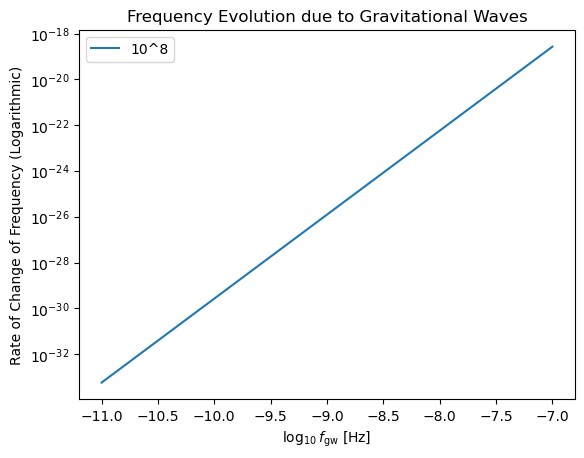

In [3]:
#now we graph dw/dt, which feels less useful but let's graph it anyway, should be quick:
from labellines import labelLine, labelLines

logFrequencySamples = np.linspace(-11, -7)


#works:
changeRates = []
m = 8
for f in range(len(logFrequencySamples)):
    changeRates.append(-freqChangeRate(10 ** m, 10 ** logFrequencySamples[f]))

#works:
fig, ax = plt.subplots()
ax.plot(logFrequencySamples, changeRates, label='10^' + str(m))
ax.set_yscale('log')
plt.xlabel(r"$\log_{10} f_{\text{gw}}$ [Hz]")
plt.ylabel("Rate of Change of Frequency (Logarithmic)")
plt.title("Frequency Evolution due to Gravitational Waves")
plt.legend()
plt.show()

OKAY! Now some test values to find out how wrong I am. Reasonable test values:
10^10 solar masses (these are, after all, supermassive black holes)
10^-3 s^-1 (these are, after all, millisecond pulsars)
experiment time is 15 yrs
distance time is 1000 yrs

we can detect change by up to a few nanohertz

In [4]:
testM = 10 ** 9
testFreq = 10 ** -8
expTime = 15
distTime = 1000

print("For 15-year experiment: " + str(changeInFreq(testM, testFreq, expTime)))
print("For 1000 years of travel time: " + str(changeInFreq(testM, testFreq, distTime)))
#by the way, it's exceedingly obnoxious that python doesn't auto-concatenate within print()
#even JAVA auto-concatenates. it seems like the kind of thing python would LOVE to do but noooooo
#dynamic typing? sure! but not when you're obviously trying to print a float, nooooo, we can't have that

print("Rate of change: " + str(freqChangeRate(testM, testFreq)))

For 15-year experiment: -1.2727302877160078e-12
For 1000 years of travel time: -8.484868584773386e-11
Rate of change: -2.6901929564912446e-21


Turns out I'm not very wrong!

Below is the code for graphing dω/dt. The hope was to eventually draw a version of this that intersected with a similar SS graph. I didn't finish that but did get somewhere pretty close I'll admit

6
7
8
9
10


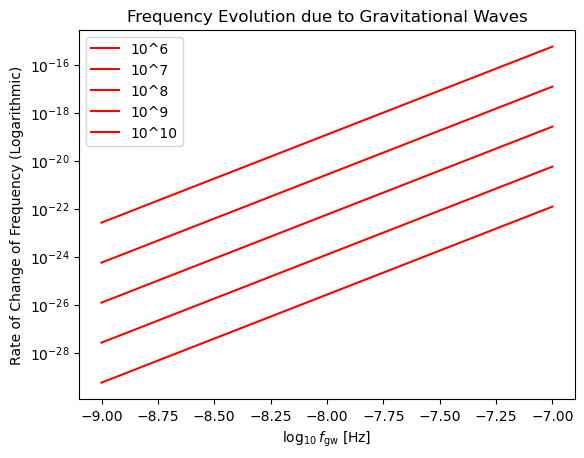

In [5]:
#now we graph dw/dt, which feels less useful but let's graph it anyway, should be quick:
from labellines import labelLine, labelLines

wSamples = np.linspace(-9, -7)
"""
wSamples = []
wInit = (10 ** -0.75) * (10 ** -9) #in hertz
for w in range(8):
    wSamples.append(wInit)
    wInit = wInit * (10 ** 0.5)
print(wSamples)
"""

masses = [0] * 5
for m in range(11 - 6):
    masses[m] = []
    for w in range(len(wSamples)):
        masses[m].append(-freqChangeRate(10 ** (m + 6), 10 ** wSamples[w]))
        
for m in range(11 - 6):
    print(m + 6)

fig, ax = plt.subplots()
for m in range(11 - 6):
    ax.plot(wSamples, masses[m], label='10^' + str(m + 6), c='r')
#ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel(r"$\log_{10} f_{\text{gw}}$ [Hz]")
plt.ylabel("Rate of Change of Frequency (Logarithmic)")
plt.title("Frequency Evolution due to Gravitational Waves")
plt.legend()
#ax.set_xticks([1, 10, 100])
#ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

Credit for the line labelling (which I did not get working lol) to: https://github.com/cphyc/matplotlib-label-lines

Below is the code for a pulsar class so I can make pulsar objects to handle the pulsar data better, see the pulsar distance distribution notebook for details

In [6]:
class Pulsar:
    def __init__(self, line):
        line = line.split()
        
        self.name = line[0]
        
        temp = line[1].split('+')
        self.meanDistance = float(temp[0])
        temporary = temp[1].split('-')
        self.plusError = float(temporary[0])
        self.minusError = float(temporary[1])
        
        self.rAsc = line[2]
        dividedUp = self.rAsc.split(':')
        hours = float(dividedUp[0])
        minutes = float(dividedUp[1])
        seconds = float(dividedUp[2])
        hours += (minutes / 60) + (seconds / 3600)
        self.phi = np.pi * hours / 12 #THIS IS IN RADIANS; DO WE WANT IT IN RADIANS?
        
        self.dec = line[3]
        divvyUp = self.dec.split(':')
        sign = divvyUp[0][0:1]
        divvyUp[0] = divvyUp[0][1:]
        degrees = float(divvyUp[0])
        minutes = float(divvyUp[1])
        seconds = float(divvyUp[2])
        degrees += (minutes / 60) + (seconds / 3600)
        if (sign.endswith('+')):
            self.theta = (np.pi/2) - (np.pi * degrees / 180)
        else:
            self.theta = (np.pi/2) + (np.pi * degrees / 180)
            
        self.pos = [np.sin(self.phi) * np.cos(self.theta), np.sin(self.phi) * np.sin(self.theta), np.cos(self.phi)]
        
    #can't do multiple constructors? evil evil evil
    
    def __str__(self):
        return str(self.name) + ", located at " + str(self.rAsc) + " " + str(self.dec)+": " + str(self.meanDistance) + "+" + str(self.plusError) + "-" + str(self.minusError) + " kpc"
    
    

Below is code to graph the change in frequency of some gravitational wave depending on pulsar distance--you input the starting frequency as baseFreq at the top of the cell. This uses the linear approximation, so it's not accurate, but it seems to work for all distances, I think? (check) At low frequencies or distances, it does match the proper evolution.

4892.34566575115


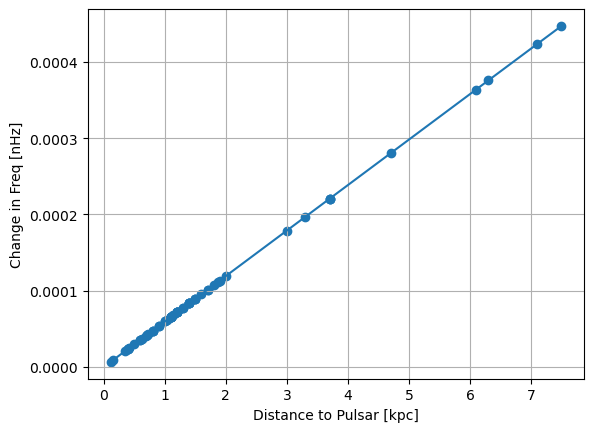

In [7]:
baseM = 10 ** 9 #solar masses
baseFreq = 10 ** -9 #in hertz (this is the orbital frequency, need to divide by pi to get GW frequency)

f = open("pulsarDistPM.txt")
pulsars = []
for x in range(65):
    pulsars.append(Pulsar(f.readline()))
    
distances = np.array([])
for x in range(65):
    distances = np.append(distances, pulsars[x].meanDistance)

times = distances * const.kpc / const.c / const.yr
times = np.sort(times)
distances = np.sort(distances)

changes = []
for x in range(65):
    changes.append(-changeInFreq(baseM, baseFreq, times[x]) * (10 ** 9))

truncatedChanges = np.delete(changes, [57, 58, 59, 60, 61, 62, 63, 64])
truncatedDistances = np.delete(distances, [57, 58, 59, 60, 61, 62, 63, 64])
print(times[46])
    
plt.scatter(distances, changes)
#plt.scatter(truncatedDistances, truncatedChanges)
plt.plot(distances, changes)
plt.xlabel("Distance to Pulsar [kpc]")
plt.ylabel("Change in Freq [nHz]")
plt.grid()

Below is a function that (I believe) was supposed to return the y values for a line showing the cutoff between something detectable and not detectable change in frequency, based on a certain boundary frequency. Did it all in log since the graph would have been in log. (Like, this should have given a black line dividing up the regions for what I used to do in color map form.) I'm not sure if it's working; I also don't know what graph it was supposed to attach to.

In [8]:
def detectableBoundary(logFreq, yrs, bound):
    #bound in hertz
    #log of frequency in hertz
    seconds = yrs * 3.154 * (10 ** 7) # convert the years to seconds
    return ((1/5)*np.log10(125 * (bound ** 3) / 884736 / seconds)) - ( (11/5) * logFreq)

Below is a function that is supposed to return the cutoff for detection based on SNR and period. I was working off a single equation typed into an email by Bence Becsy where variables were not named and latex did not render, so I have no idea if I interpreted it correctly. It also doesn't work because I don't know what's going on in terms of units or scale.

In [9]:
def getBoundary(snr, period):
    #period in seconds
    return (3 ** (1/2)) / (np.pi * period * snr)

SNR stuff: $\sigma_f = \frac{\sqrt{3}}{\pi T \text{SNR}}$

where (I believe)
- $T$ is the period
- $\sigma_f$ is some statistics thing that I'm not sure how to translate into any of my graphs, so for now I will assume it's our desired $\Delta \f$
- SNR is signal to noise ratio and this, at least, I'm positive of

Below is the code for a color map that shows how much the frequency changes depending on chirp mass and initial frequency.

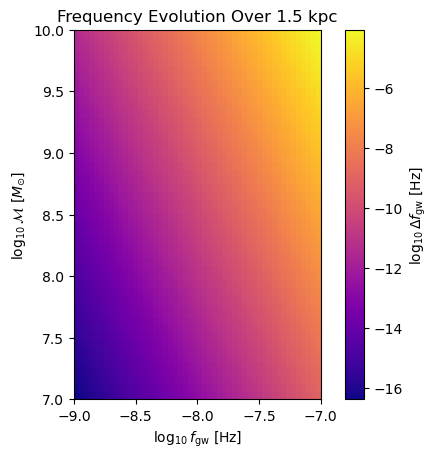

In [10]:
logMSamples = np.linspace(10, 7)
logWSamples = np.linspace(-9, -7)
testDist = 1.5
testYears = 3261.56 * testDist
bound = 2e-9

vals = [0] * len(logMSamples)
for M in range(len(logMSamples)):
    vals[M] = []
    for w in range(len(logWSamples)):
        vals[M].append(np.log10(-changeInFreq(10 ** logMSamples[M], 10 ** logWSamples[w], testYears))) #1.5kpc

        """
bounds = []
for x in range(len(logWSamples)):
    bounds.append(detectableBoundary(logWSamples[x], testYears, bound))"""
        
plt.imshow(vals, extent=[-9, -7, 7, 10], cmap="plasma") #gist_rainbow gives more detail
plt.colorbar(label=r"$\log_{10} \Delta f_{\text{gw}}$ [Hz]")
plt.xlabel(r"$\log_{10}f_{\text{gw}}$ [Hz]")
plt.ylabel(r"$\log_{10}\mathcal{M}\ [M_{\odot}$]")
plt.title("Frequency Evolution Over 1.5 kpc")
#plt.plot(logWSamples, bounds, color="black")
plt.ylim(min(logMSamples), max(logMSamples))
plt.show()

This matches the distance plot like it's supposed to, as far as I can tell (it's harder to tell here, but it's the same spread of values, just finer)

Below is the code for a color map that is yellow where the signal is detectable and navy blue where the signal is not detectable. For this, the detection cutoff is 1nHz. The color mapping here is questionable; I don't remember for sure, but I think I might not have understood imshow properly when I made this, so it might be completely wrong. (same goes for the above graph honestly) StellarScatteringSesana_wAstropy has correct color maps for frequency evolution, although it currently doesn't have any color maps that *only* show evolution due to GW radiation.

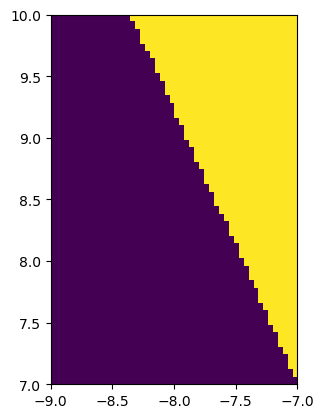

In [11]:
logMVals = np.linspace(10, 7)
logWVals = np.linspace(-9, -7)

evalues = [0] * len(logMVals)
for M in range(len(logMVals)):
    evalues[M] = []
    for w in range(len(logWVals)):
        evalues[M].append(np.log10(-changeInFreq(10 ** logMVals[M], 10 ** logWVals[w], 3261.56 * 1.5))) #1.5kpc

boundaries = [0] * len(logMVals)
for m in range(len(logMVals)):
    boundaries[m] = []
    for w in range(len(logWVals)):
        if evalues[m][w] > -9:
            boundaries[m].append(1)
        else:
            boundaries[m].append(0)


plt.imshow(boundaries, extent=[-9, -7, 7, 10])
plt.show()